In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt 
from sklearn.linear_model import Ridge
%matplotlib inline

In [2]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"
df = pd.read_csv(url)
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


<Axes: xlabel='median_house_value', ylabel='Count'>

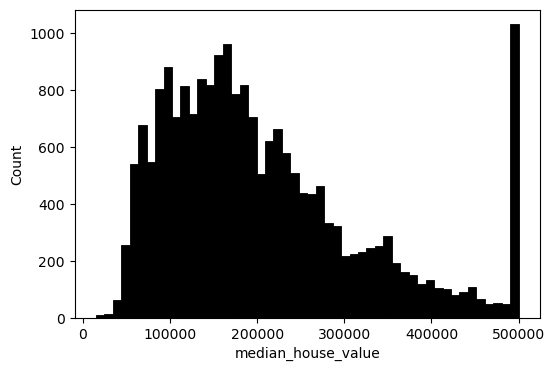

In [3]:
plt.figure(figsize=(6,4))

sns.histplot(df['median_house_value'],bins=50,color='black',alpha=1) 

In [4]:
df = df[df.ocean_proximity.isin(["<1H OCEAN", "INLAND"])]
FEATURES = [
    "latitude",
    "longitude",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households",
    "median_income",
    "median_house_value",
]
df = df[FEATURES]

In [5]:
df.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

In [6]:
df['population'].median()

1195.0

In [7]:
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - (n_val + n_test)
n, n_train, n_val, n_test

df_train = df.iloc[:n_train]
df_val = df.iloc[n_train : n_train + n_val]
df_test = df.iloc[n_train + n_val :]
idx = np.arange(n)

np.random.seed(42)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train : n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val :]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train["median_house_value"]
del df_val["median_house_value"]
del df_test["median_house_value"]

len(df_train), len(df_val), len(df_test)



(9413, 3137, 3137)

In [8]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]  


def rmse(y, y_pred):
    return np.sqrt(np.mean((y - y_pred)**2))


def  prepare_x(df):
    df_num = df.copy()
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

def prepare_X_with_mean(df, train_mean=None):
    df_num = df.copy()
    if train_mean is not None:
        df_num.fillna(train_mean, inplace=True)
    X = df_num.values
    return X

def train_linear_regression_reg(X, y, r = 0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])  
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0]) 
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    return w_full[0], w_full[1:]  

In [9]:
train_mean = df_train.mean()

X_train = prepare_X_with_mean(df_train, train_mean)
w0, w = train_linear_regression(X_train, y_train)
y_pred = w0 + X_train.dot(w)
rmse_train = rmse(y_train, y_pred)

X_val = prepare_X_with_mean(df_val, train_mean)
y_pred = w0 + X_val.dot(w)
rmse_val = rmse(y_val, y_pred)

df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)
X_full_train = prepare_X_with_mean(df_full_train, train_mean)
y_full_train = np.concatenate([y_train, y_val])

w0, w = train_linear_regression(X_full_train, y_full_train)

X_test = prepare_X_with_mean(df_test, train_mean)
y_pred = w0 + X_test.dot(w)
rmse_test = rmse(y_test, y_pred)

print("Train RMSE: {:.2f}".format(rmse_train))
print("Validation RMSE: {:.2f}".format(rmse_val))
print("Test RMSE: {:.2f}".format(rmse_test))

Train RMSE: 0.34
Validation RMSE: 0.34
Test RMSE: 0.33


In [10]:
reg_values = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

best_rmse = float("inf")
best_reg = None

for reg_value in reg_values:
    X_train = prepare_x(df_train)
    w0, w = train_linear_regression(X_train, y_train)

    model = Ridge(alpha=reg_value)
    model.fit(X_train, y_train)

    X_val = prepare_x(df_val)
    y_pred_val = model.predict(X_val)

    rmse_val = rmse(y_val, y_pred_val)

    if rmse_val < best_rmse:
        best_rmse = rmse_val
        best_reg = reg_value

print(
    f"Best RMSE on Validation set: {round(best_rmse, 2)} with regularization value r = {best_reg}"
)

X_full_train = prepare_x(pd.concat([df_train, df_val]))
y_full_train = np.concatenate([y_train, y_val])
model = Ridge(alpha=best_reg)
model.fit(X_full_train, y_full_train)

X_test = prepare_x(df_test)
y_pred_test = model.predict(X_test)
rmse_test = rmse(y_test, y_pred_test)

print("Test RMSE with Best Regularization: {:.2f}".format(rmse_test))

Best RMSE on Validation set: 0.34 with regularization value r = 0
Test RMSE with Best Regularization: 0.33


In [11]:
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

rmse_scores = []

for seed in seed_values:
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
    df_val = df.iloc[idx[n_train : n_train + n_val]].reset_index(drop=True)
    df_test = df.iloc[idx[n_train + n_val :]].reset_index(drop=True)

    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)

    del df_train["median_house_value"]
    del df_val["median_house_value"]
    del df_test["median_house_value"]

    X_train = prepare_x(df_train)
    w0, w = train_linear_regression(X_train, y_train)
    y_pred_val = w0 + prepare_x(df_val).dot(w)
    rmse_val = rmse(y_val, y_pred_val)

    rmse_scores.append(rmse_val)

std_deviation = round(np.std(rmse_scores), 3)

print(f"Standard Deviation of RMSE Scores: {std_deviation}")



Standard Deviation of RMSE Scores: 0.005


In [12]:
seed = 9
np.random.seed(seed)

idx = np.arange(n)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
df_val = df.iloc[idx[n_train : n_train + n_val]].reset_index(drop=True)
df_test = df.iloc[idx[n_train + n_val :]].reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train["median_house_value"]
del df_val["median_house_value"]
del df_test["median_house_value"]

df_combined_train = pd.concat([df_train, df_val])
df_combined_train = df_combined_train.reset_index(drop=True)

y_combined_train = np.concatenate([y_train, y_val])

X_combined_train = prepare_x(df_combined_train)
X_test = prepare_x(df_test)

reg_value = 0.001
model = Ridge(alpha=reg_value)
model.fit(X_combined_train, y_combined_train)

y_pred_test = model.predict(X_test)

rmse_test = rmse(y_test, y_pred_test)

print("Test RMSE with r=0.001: {:.2f}".format(rmse_test))

Test RMSE with r=0.001: 0.33
